#### Step 1: Preprocess data 

Prepare the MNIST data set for training by normalizing the pixel values and reshaping the images to have a single color channel. Normalization helps in faster convergence during training, and reshaping is required because the input layer of your diffusion model expects a three-dimensional tensor. 

**1. Load and preprocess the MNIST data set:**

- Use Keras to load the MNIST data set. 
- Normalize the image pixel values to the range [0, 1]. 

**2. Reshape the Data:**
- Expand the dimensions of the images to match the input shape required by the model (28x28x1). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

In [2]:
# Load the data set  
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values  
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)  
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#### Step 2: Build the diffusion model 

Build a simple diffusion model with an encoder that compresses the input image into a latent representation and a decoder that reconstructs the image from this representation. The model is compiled with the Adam optimizer and binary cross-entropy loss. 

**1. Define the encoder:**
- Create an input layer with the shape (28, 28, 1). 
- Add two Conv2D layers with increasing filter sizes and ReLU activation. 

**2. Define the bottleneck:**
- Add a flattened layer followed by a dense layer with ReLU activation. 

**3. Define the decoder:**
- Add a Dense layer to expand the bottleneck representation.  
- Reshape the output to match the original image dimensions.  
- Add two Conv2DTranspose layers with decreasing filter sizes and ReLU activation.
  
**4. Compile the model:**
- Use the Adam optimizer and binary cross-entropy loss. 


In [3]:
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x)  # Reduced size
x = Dense(28*28*32, activation='relu')(x)  # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 25088)             1630720   
                                                                 
 reshape (Reshape)           (None, 28, 28, 32)        0     

#### Step 3: Add noise to the data 

Add random noise to the data set to simulate the diffusion process: 
- Add Gaussian noise to the training and test data sets.  
- Clip the values to ensure they remain within the valid range [0, 1].  

In [4]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

#### Step 4: Train the diffusion model 

Train the diffusion model to denoise the MINIST images. Use the noisy images as input and the original images as the target, learning to reverse the noise addition process. 
- Use the ‘fit’ method to train the model on the noisy training data. 
- Set the number of epochs to 50 and the batch size to 128. 

In [5]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 [==============================] - 83s 32ms/step - loss: 0.0344 - val_loss: 0.0169
Epoch 2/3
938/938 [==============================] - 30s 32ms/step - loss: 0.0132 - val_loss: 0.0135
Epoch 3/3
938/938 [==============================] - 30s 32ms/step - loss: 0.0113 - val_loss: 0.0127


#### Step 5: Evaluate the diffusion model 

Evaluate the performance of the trained diffusion model by predicting the denoised images and visualizing the results. Comparing the original, noisy, and denoised images will help you understand how well the model has learned to remove noise from the images. 

**1. Reconstruct images:**
- Use the diffusion model to predict the denoised test images.  
- Compare the original, noisy, and denoised images. 

**2. Visualize the results:**
- Plot a few examples of original, noisy, and denoised images side by side.

313/313 [==============================] - 3s 8ms/step


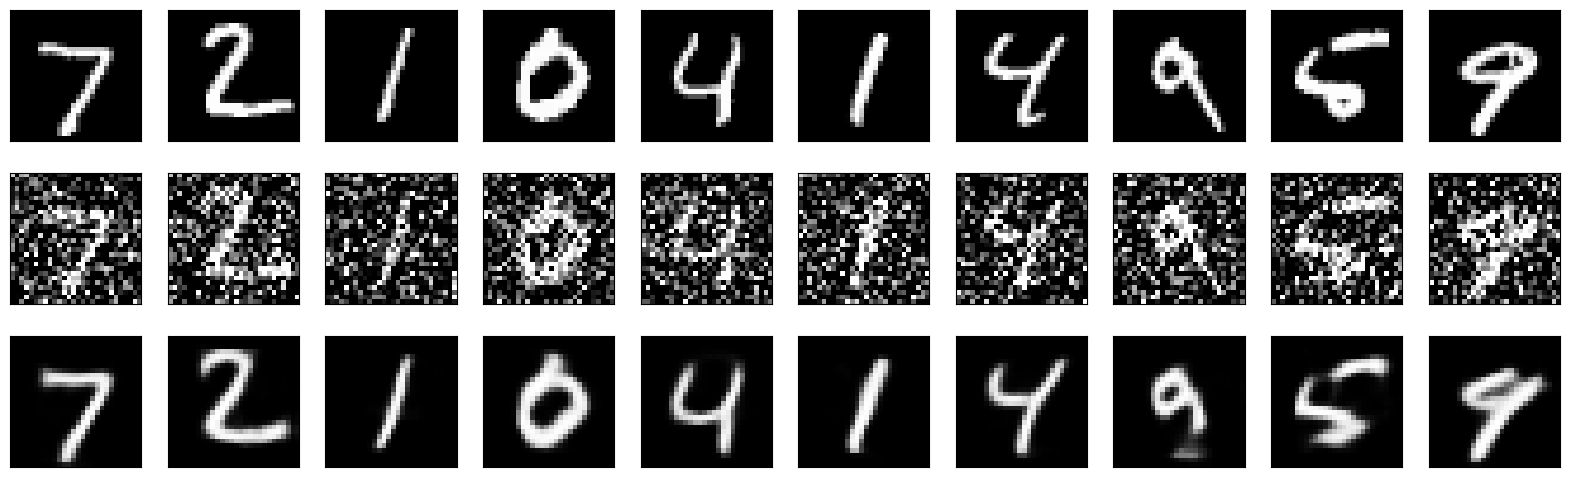

In [6]:
# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Step 6: Fine-tune the diffusion model 

Fine-tune the diffusion model by unfreezing some layers and retraining the model to improve its performance. 

**1. Unfreeze the model layers:** 
- Unfreeze the last few layers of the model to allow them to be retrained. 

**2. Compile and train the model:** 
- Recompile the model. 
- Train the model again for an additional 10 epochs. 

In [7]:
# Unfreeze the top layers of the model
for layer in diffusion_model.layers[-4:]:
    layer.trainable = True

# Compile the model again
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model again
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=10,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))

Epoch 1/10
938/938 [==============================] - 33s 34ms/step - loss: 0.0936 - val_loss: 0.0961
Epoch 2/10
938/938 [==============================] - 32s 35ms/step - loss: 0.0902 - val_loss: 0.0966
Epoch 3/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0874 - val_loss: 0.0985
Epoch 4/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0853 - val_loss: 0.0986
Epoch 5/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0835 - val_loss: 0.1002
Epoch 6/10
938/938 [==============================] - 31s 34ms/step - loss: 0.0820 - val_loss: 0.1011
Epoch 7/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0809 - val_loss: 0.1029
Epoch 8/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0799 - val_loss: 0.1043
Epoch 9/10
938/938 [==============================] - 32s 35ms/step - loss: 0.0791 - val_loss: 0.1051
Epoch 10/10
938/938 [==============================] - 32s 34ms/step - loss: 0.078

### Exercise 1: Modify the noise factor  

#### Objective: 
- Change the noise factor and see how it affects the model’s ability to denoise images.
#### Instructions:  
1. Change the noise factor to 0.3.  
2. Add noise to the training and test data sets with the new noise factor.  
3. Retrain the model with the new noisy data.

In [8]:
# Change the noise factor to 0.3
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values to ensure they remain in the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Retrain the model
diffusion_model.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/10
938/938 [==============================] - 33s 35ms/step - loss: 0.0795 - val_loss: 0.0781
Epoch 2/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0774 - val_loss: 0.0775
Epoch 3/10
938/938 [==============================] - 33s 35ms/step - loss: 0.0766 - val_loss: 0.0771
Epoch 4/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0760 - val_loss: 0.0772
Epoch 5/10
938/938 [==============================] - 45s 48ms/step - loss: 0.0755 - val_loss: 0.0768
Epoch 6/10
938/938 [==============================] - 41s 44ms/step - loss: 0.0750 - val_loss: 0.0769
Epoch 7/10
938/938 [==============================] - 22s 23ms/step - loss: 0.0745 - val_loss: 0.0769
Epoch 8/10
938/938 [==============================] - 24s 26ms/step - loss: 0.0739 - val_loss: 0.0770
Epoch 9/10
938/938 [==============================] - 21s 23ms/step - loss: 0.0733 - val_loss: 0.0774
Epoch 10/10
938/938 [==============================] - 21s 23ms/step - loss: 0.072

### Exercise 2 - Add more layers to the model  

#### Objective: 
- Experiment with adding more layers to the model to see how it affects performance.

#### Instructions:
1. Add an additional Conv2D layer with 128 filters in the encoder.  
2. Add an additional Conv2DTranspose layer with 128 filters in the decoder.  
3. Rebuild, compile, and train the model.

In [11]:
# Ensure GPU compatibility and clear TensorFlow session
from tensorflow.keras.backend import clear_session
clear_session()

# Check GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Ensure data types are compatible with GPU
x_train_noisy = tf.convert_to_tensor(x_train_noisy, dtype=tf.float32)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_noisy = tf.convert_to_tensor(x_test_noisy, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)

# Redefine the model with additional layers
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Added layer
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(28 * 28 * 32, activation='relu')(x)
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)  # Added layer
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the new model
diffusion_model = Model(input_layer, output_layer)
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')

# Reduce batch size and train the updated model
diffusion_model.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=16,  # Further reduced batch size to alleviate memory issues
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Num GPUs Available:  1


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

### Exercise 3: Visualize the effect of noise  

#### Objective: 
- Compare the impact of different noise levels on the denoising performance of the model.

#### Instructions:  
1. Add noise with different factors (e.g., 0.1, 0.5, 0.7) to the test data.  
2. Use the model to predict the denoised images for each noise level.  
3. Visualize the original, noisy, and denoised images side by side for each noise level.

313/313 [==============================] - 2s 8ms/step


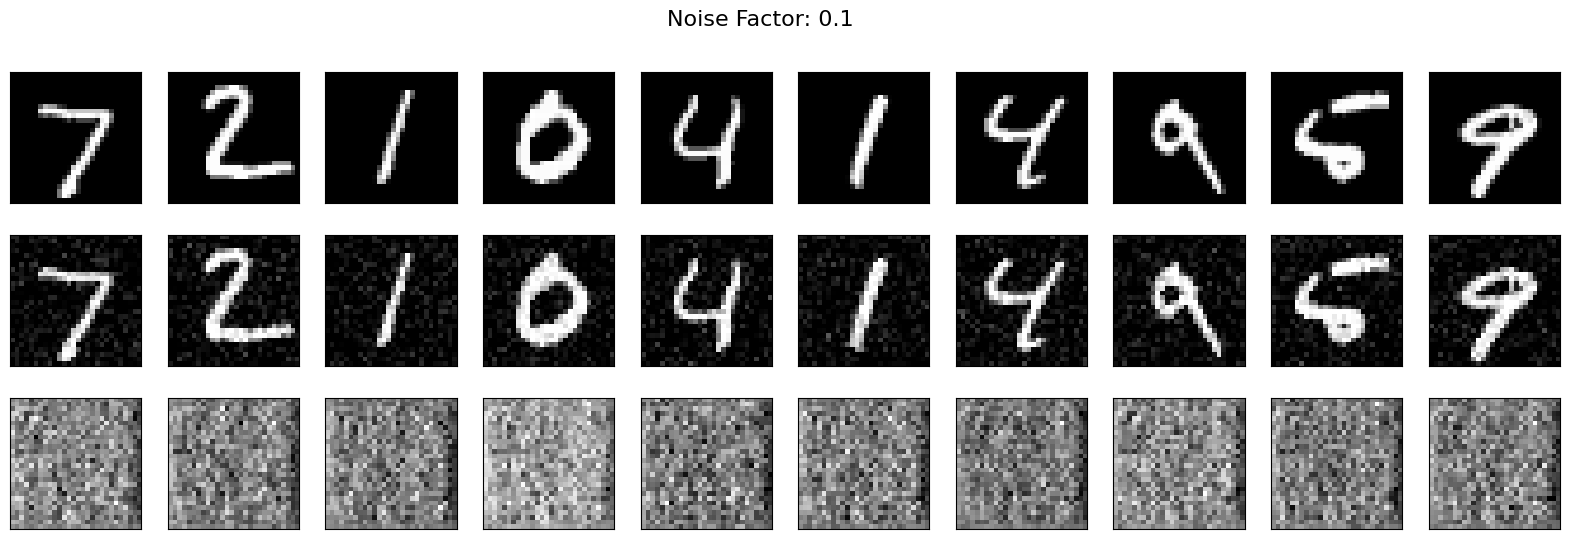

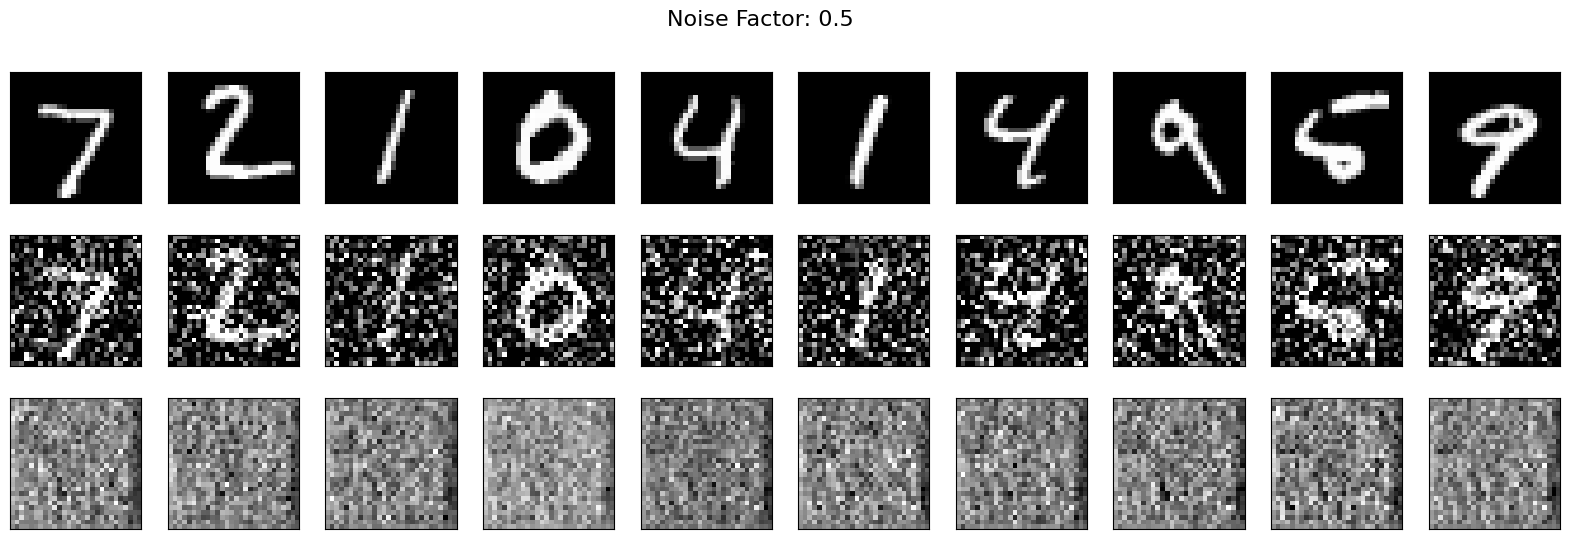

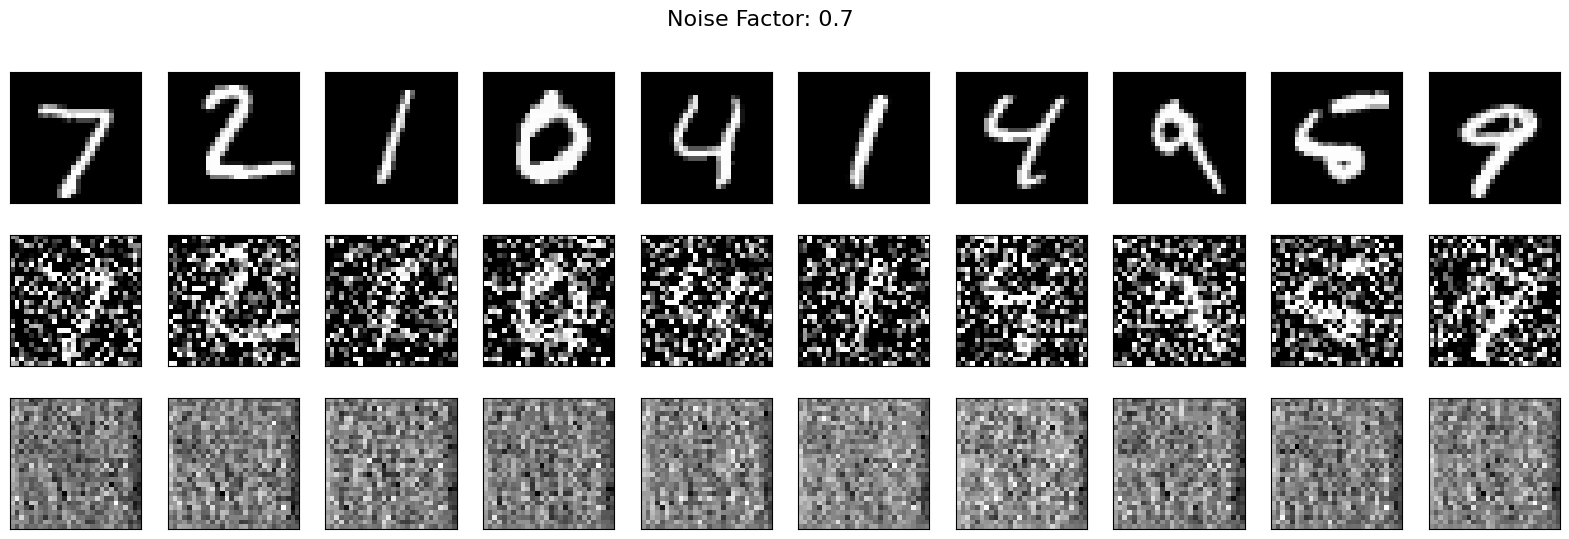

In [12]:
# Function to add noise with different factors
def add_noise(data, noise_factor):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy_data, 0., 1.)

# Test different noise factors
noise_factors = [0.1, 0.5, 0.7]
noisy_images = {factor: add_noise(x_test, factor) for factor in noise_factors}

# Predict denoised images for each noise factor
denoised_images = {factor: diffusion_model.predict(images) for factor, images in noisy_images.items()}

# Visualize the results
n = 10  # Number of digits to display
for noise_factor, noisy_data in noisy_images.items():
    denoised = denoised_images[noise_factor]
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'Noise Factor: {noise_factor}', fontsize=16)
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_data[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Denoised
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Summary  

By completing these exercises, students will:  
1. Understand the impact of different noise factors on the model’s denoising capabilities.
2. Learn how adding more layers to the model affects its performance.
3. Visualize how different levels of noise affect the denoising results of the model. 